In [54]:
#Pacotes de manipulação de dados
import os
import pandas as pd
import numpy as np

#Pacote Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Pacote de modelagem
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from sqlalchemy import create_engine
import sqlite3
from urllib.parse import quote_plus
import cryptography

#Pacotes de modelagem de ESTATISTICAS
import statsmodels.api as sm



# Criando função Information Value (IV) e Weight of Evidence (WoE)
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extraindo nomes da coluna
    cols = data.columns
    
    #Execute WOE e IV em todas as variáveis ​​independentes
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0).sort_values(by='IV', ascending=False)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Mostrar tabela WOE
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [2]:
df_amazon = pd.read_csv(r'C:\Users\ale\Desktop\Python\Arquivo_Procon\1-Amazon.com.br.csv', sep=';')
df_amazon

,Gestor,Canal de Origem,Região,UF,Cidade,Sexo,Faixa Etária,Ano Abertura,Mês Abertura,Data Abertura,...,Como Comprou Contratou,Procurou Empresa,Respondida,Situação,Avaliação Reclamação,Nota do Consumidor,Análise da Recusa,Arquivo_Origem,Grupo Econômico,ArquivoOrigem
0,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,M,entre 31 a 40 anos,2020.0,12.0,23/12/2020,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,NaN,NaN
1,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 21 a 30 anos,2020.0,12.0,23/12/2020,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,NaN,NaN
2,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 41 a 50 anos,2020.0,12.0,24/12/2020,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,NaN,NaN
3,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Aparecida de Goiânia,F,entre 51 a 60 anos,2020.0,12.0,25/12/2020,...,Internet,S,N,Cancelada,NaN,NaN,Procedente,amplo2020-12.csv,NaN,NaN
4,Fundação de Proteção e Defesa do Consumidor,Plataforma Android,SE,SP,Campinas,M,entre 31 a 40 anos,2020.0,12.0,26/12/2020,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42552,Secretaria de Justiça e Direitos Humanos - Sec...,Plataforma Web,NE,PE,Jaboatão dos Guararapes,M,entre 41 a 50 anos,2025.0,4.0,25/04/2025,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,NaN,NaN
42553,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Águas Lindas de Goiás,M,entre 31 a 40 anos,2025.0,4.0,25/04/2025,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,NaN,NaN
42554,Secretaria Nacional do Consumidor,Plataforma Web,CO,DF,Brasília,M,entre 31 a 40 anos,2025.0,4.0,25/04/2025,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,NaN,NaN
42555,Departamento Estadual de Proteção e Defesa do ...,Plataforma Web,S,PR,Curitiba,M,entre 31 a 40 anos,2025.0,4.0,25/04/2025,...,Não comprei / contratei,S,S,Finalizada avaliada,Resolvida,4.0,NaN,basecompleta2025-04.csv,NaN,NaN


In [3]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42557 entries, 0 to 42556
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gestor                  42557 non-null  object 
 1   Canal de Origem         42557 non-null  object 
 2   Região                  42557 non-null  object 
 3   UF                      42557 non-null  object 
 4   Cidade                  42557 non-null  object 
 5   Sexo                    42556 non-null  object 
 6   Faixa Etária            42557 non-null  object 
 7   Ano Abertura            42557 non-null  float64
 8   Mês Abertura            42557 non-null  float64
 9   Data Abertura           42557 non-null  object 
 10  Data Resposta           32460 non-null  object 
 11  Data Análise            12512 non-null  object 
 12  Data Recusa             13136 non-null  object 
 13  Data Finalização        42557 non-null  object 
 14  Prazo Resposta          42557 non-null

In [4]:
df_amazon = df_amazon.drop(columns=['Prazo Analise Gestor', 'Tempo Resposta', 'ArquivoOrigem', 'Grupo Econômico'], axis=1, errors='ignore')

In [5]:
df_amazon = df_amazon.rename(columns={
    'Gestor': 'gestor',
    'Região': 'regiao',
    'UF': 'uf',
    'Cidade': 'cidade',
    'Sexo': 'sexo',
    'Área': 'area',
    'Assunto': 'assunto',
    'Arquivo_Origem': 'arquivo_origem',
    'Data Abertura': 'data_abertura',
    'Data Resposta': 'data_resposta',
    'Data Análise': 'data_analise',
    'Data Recusa': 'data_recusa',
    'Data Finalização': 'data_finalizacao',
    'Faixa Etária': 'faixa_etaria',
    'Tempo Resposta Meses': 'tempo_resposta_meses',
    'Tempo Resposta Dias': 'tempo_resposta_dias',
    'Tempo Análise Dias': 'tempo_analise_dias',
    'Tempo Finalização Dias': 'tempo_finalizacao_dias',
    'Canal de Origem': 'canal_origem',
    'Ano Abertura': 'ano_abertura',
    'Mês Abertura': 'mes_abertura',
    'Prazo Resposta': 'prazo_resposta',
    'Nome Fantasia': 'nome_fantasia',
    'Segmento de Mercado': 'segmento_mercado',
    'Grupo Problema': 'grupo_problema',
    'Como Comprou Contratou': 'como_comprou_contatrou',
    'Procurou Empresa': 'procurou_empresa',
    'Avaliação Reclamação': 'avaliacao_reclamacao',
    'Nota do Consumidor': 'nota_consumidor',
    'Análise da Recusa': 'analise_recusa',   
})

In [6]:
df_amazon.isnull().sum()

gestor                        0
canal_origem                  0
regiao                        0
uf                            0
cidade                        0
sexo                          1
faixa_etaria                  0
ano_abertura                  0
mes_abertura                  0
data_abertura                 0
data_resposta             10097
data_analise              30045
data_recusa               29421
data_finalizacao              0
prazo_resposta                0
nome_fantasia                 0
segmento_mercado              0
area                          0
assunto                       0
grupo_problema                0
Problema                      0
como_comprou_contatrou        0
procurou_empresa              0
Respondida                    0
Situação                      0
avaliacao_reclamacao       7529
nota_consumidor           22558
analise_recusa            29438
arquivo_origem                0
dtype: int64

In [7]:
df_amazon['sexo'] = df_amazon['sexo'].fillna('N/A')
df_amazon['sexo'] = df_amazon['sexo'].replace({'O': 'N/A'})
df_amazon['avaliacao_reclamacao'] = df_amazon['avaliacao_reclamacao'].fillna('Não Resolvida')

In [8]:
df_amazon = df_amazon.astype({
    'ano_abertura': 'int',
    'mes_abertura': 'int',
})

In [9]:
from dateutil.relativedelta import relativedelta
# 1. Lista das colunas de data
colunas_data = [
    'data_abertura', 'data_resposta', 'data_analise',
    'data_recusa', 'data_finalizacao', 'prazo_resposta'
]

# 2. Converter as colunas para datetime
for col in colunas_data:
    df_amazon[col] = pd.to_datetime(df_amazon[col], dayfirst=True, errors='coerce')

# Função para calcular diferença em meses ou retornar 0
def calcular_meses(row):
    abertura = row['data_abertura']
    resposta = row['data_resposta']
    
    if pd.notnull(abertura) and pd.notnull(resposta):
        rd = relativedelta(resposta, abertura)
        return rd.years * 12 + rd.months
    else:
        return 0  # Ausência de resposta → 0 meses

# Criação da nova coluna
df_amazon['tempo_resposta_meses'] = df_amazon.apply(calcular_meses, axis=1)

# Calcula a diferença em dias somente onde ambas as datas não são nulas, senão coloca 0
df_amazon['dias_diferenca'] = (
    (df_amazon['data_resposta'] - df_amazon['data_abertura']).dt.days
).where(
    df_amazon['data_resposta'].notnull() & df_amazon['data_abertura'].notnull(),
    0
)

C:\Users\ale\AppData\Local\Temp\ipykernel_15220\225156451.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_amazon[col] = pd.to_datetime(df_amazon[col], dayfirst=True, errors='coerce')


In [10]:
# Lista das colunas de datas
colunas_data = [
    'data_abertura', 'data_resposta', 'data_analise',
    'data_recusa', 'data_finalizacao', 'prazo_resposta'
]

# 1. Converte para datetime com dayfirst
for col in colunas_data:
    df_amazon[col] = pd.to_datetime(df_amazon[col], dayfirst=True, errors='coerce')

# # 2. Formata como string com o formato brasileiro, incluindo hora
# for col in colunas_data:
#     df_amazon[col] = df_amazon[col].dt.strftime('%d/%m/%Y')

In [11]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42557 entries, 0 to 42556
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   gestor                  42557 non-null  object        
 1   canal_origem            42557 non-null  object        
 2   regiao                  42557 non-null  object        
 3   uf                      42557 non-null  object        
 4   cidade                  42557 non-null  object        
 5   sexo                    42557 non-null  object        
 6   faixa_etaria            42557 non-null  object        
 7   ano_abertura            42557 non-null  int64         
 8   mes_abertura            42557 non-null  int64         
 9   data_abertura           42557 non-null  datetime64[ns]
 10  data_resposta           32460 non-null  datetime64[ns]
 11  data_analise            12512 non-null  datetime64[ns]
 12  data_recusa             13136 non-null  dateti

In [12]:
df_amazon

,gestor,canal_origem,regiao,uf,cidade,sexo,faixa_etaria,ano_abertura,mes_abertura,data_abertura,...,como_comprou_contatrou,procurou_empresa,Respondida,Situação,avaliacao_reclamacao,nota_consumidor,analise_recusa,arquivo_origem,tempo_resposta_meses,dias_diferenca
0,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,M,entre 31 a 40 anos,2020,12,2020-12-23,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,6.0
1,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 21 a 30 anos,2020,12,2020-12-23,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,6.0
2,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 41 a 50 anos,2020,12,2020-12-24,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,5.0
3,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Aparecida de Goiânia,F,entre 51 a 60 anos,2020,12,2020-12-25,...,Internet,S,N,Cancelada,Não Resolvida,NaN,Procedente,amplo2020-12.csv,0,0.0
4,Fundação de Proteção e Defesa do Consumidor,Plataforma Android,SE,SP,Campinas,M,entre 31 a 40 anos,2020,12,2020-12-26,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42552,Secretaria de Justiça e Direitos Humanos - Sec...,Plataforma Web,NE,PE,Jaboatão dos Guararapes,M,entre 41 a 50 anos,2025,4,2025-04-25,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0
42553,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Águas Lindas de Goiás,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0
42554,Secretaria Nacional do Consumidor,Plataforma Web,CO,DF,Brasília,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0
42555,Departamento Estadual de Proteção e Defesa do ...,Plataforma Web,S,PR,Curitiba,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Não comprei / contratei,S,S,Finalizada avaliada,Resolvida,4.0,NaN,basecompleta2025-04.csv,0,4.0


In [13]:
df_amazon.avaliacao_reclamacao = df_amazon.avaliacao_reclamacao.fillna('Não Avaliada')

C:\Users\ale\AppData\Local\Temp\ipykernel_15220\408070346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_problemas.values, y=top_problemas.index, palette="viridis")


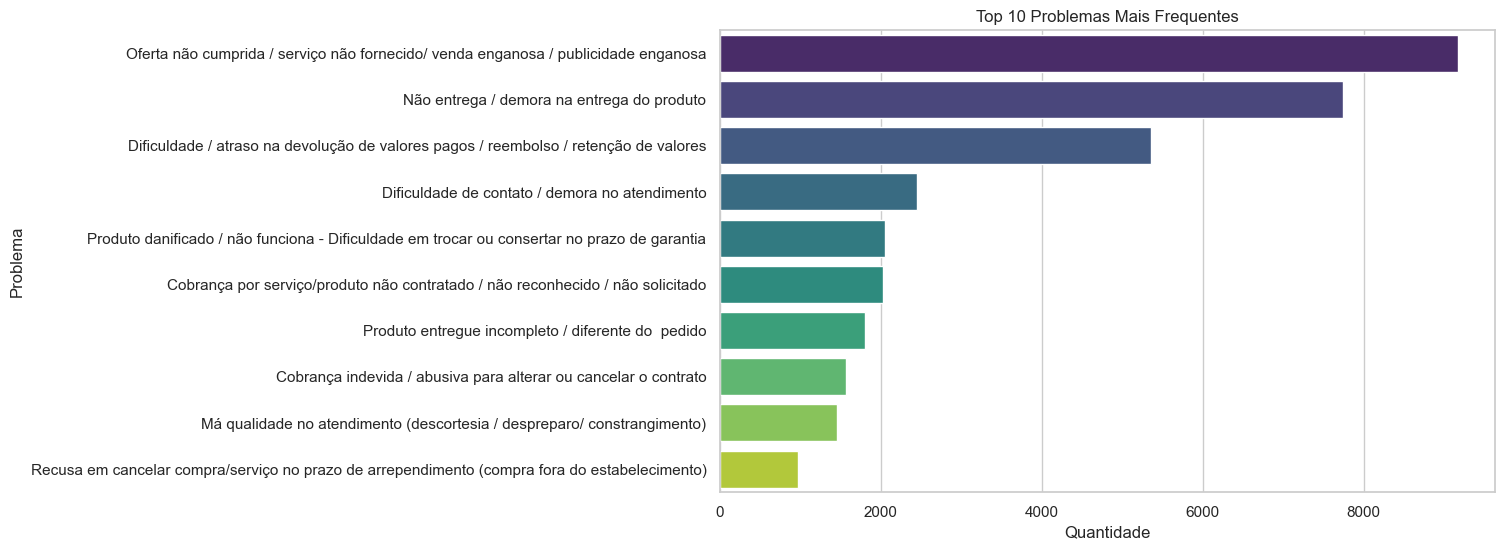

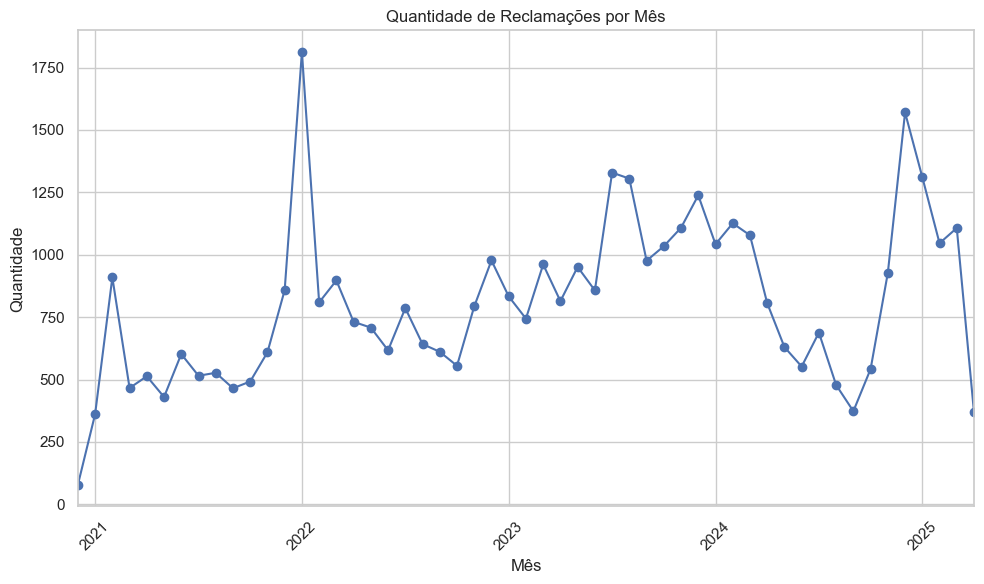

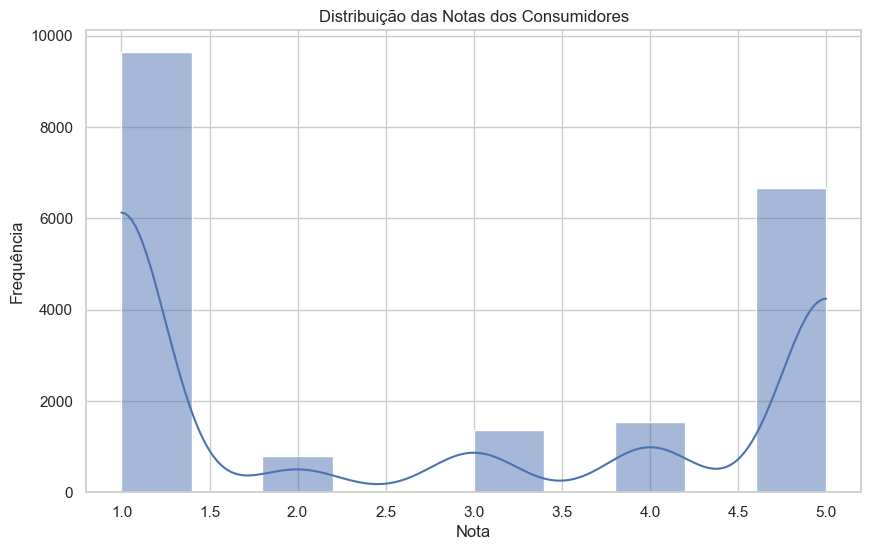

C:\Users\ale\AppData\Local\Temp\ipykernel_15220\408070346.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_amazon, y='avaliacao_reclamacao', order=df_amazon['avaliacao_reclamacao'].value_counts().index, palette="magma")


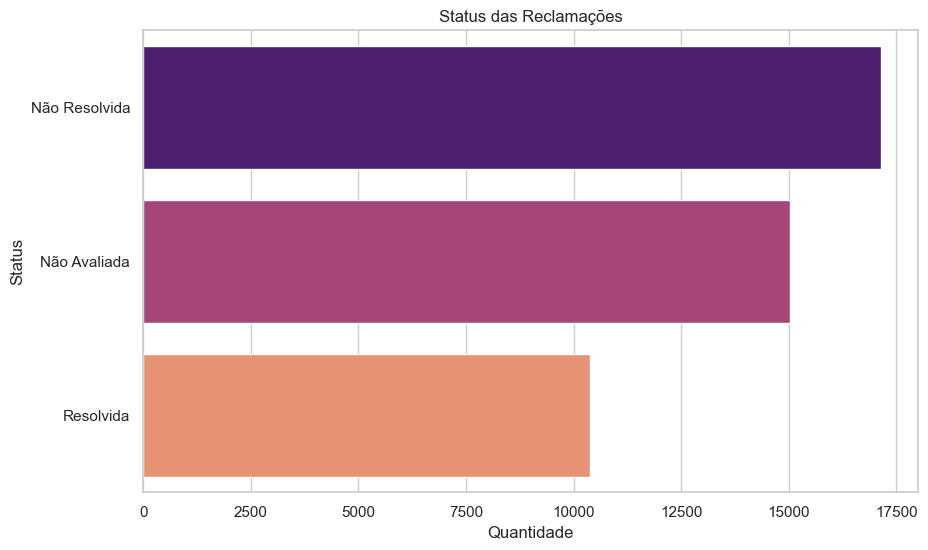

In [14]:

# Estilo padrão dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Exemplo 1: Frequência dos principais problemas
top_problemas = df_amazon['Problema'].value_counts().head(10)
sns.barplot(x=top_problemas.values, y=top_problemas.index, palette="viridis")
plt.title("Top 10 Problemas Mais Frequentes")
plt.xlabel("Quantidade")
plt.ylabel("Problema")
plt.show()

# Exemplo 2: Reclamações por mês
# df_amazon['data_abertura'] = pd.to_datetime(df_amazon['data_abertura'], errors='coerce', dayfirst=True)
df_amazon['mes_ano'] = df_amazon['data_abertura'].dt.to_period("M")
reclamacoes_mensais = df_amazon['mes_ano'].value_counts().sort_index()
reclamacoes_mensais.plot(kind='line', marker='o')
plt.title("Quantidade de Reclamações por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Exemplo 3: Distribuição das notas dos consumidores
sns.histplot(df_amazon['nota_consumidor'].dropna(), bins=10, kde=True)
plt.title("Distribuição das Notas dos Consumidores")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.show()

# Exemplo 4: Resumo da situação (resolvida, não resolvida etc.)
sns.countplot(data=df_amazon, y='avaliacao_reclamacao', order=df_amazon['avaliacao_reclamacao'].value_counts().index, palette="magma")
plt.title("Status das Reclamações")
plt.xlabel("Quantidade")
plt.ylabel("Status")
plt.show()

In [15]:
# Total de reclamações
total_reclamacoes = len(df_amazon)
print(f"Total de reclamações: {total_reclamacoes:,}")

# Nota média dos consumidores
nota_media = df_amazon['nota_consumidor'].mean()
print(f"Nota média dos consumidores: {nota_media:.2f}")

# Percentual de reclamações resolvidas
percent_resolvidas = (df_amazon['avaliacao_reclamacao'] == 'Resolvida').mean() * 100
print(f"Percentual de reclamações resolvidas: {percent_resolvidas:.1f}%")

# Tempo médio de resposta (em dias)
# df_amazon['data_resposta'] = pd.to_datetime(df_amazon['data_resposta'], errors='coerce', dayfirst=True)
# df_amazon['tempo_resposta'] = (df_amazon['data_resposta'] - df_amazon['data_abertura']).dt.days
tempo_medio_resposta = df_amazon['dias_diferenca'].mean()
print(f"Tempo médio de resposta: {tempo_medio_resposta:.1f} dias")

# Problemas mais recorrentes
problemas_recor = df_amazon['Problema'].value_counts().head(3)
print("\nTop 3 problemas mais recorrentes:")
print(problemas_recor.to_string(index=True, header=False))

Total de reclamações: 42,557
Nota média dos consumidores: 2.74
Percentual de reclamações resolvidas: 24.4%
Tempo médio de resposta: 5.4 dias

Top 3 problemas mais recorrentes:
Oferta não cumprida / serviço não fornecido/ venda enganosa / publicidade enganosa      9169
Não entrega / demora na entrega do produto                                              7750
Dificuldade / atraso na devolução de valores pagos / reembolso / retenção de valores    5356


In [16]:
df_amazon.isnull().sum()

gestor                        0
canal_origem                  0
regiao                        0
uf                            0
cidade                        0
sexo                          0
faixa_etaria                  0
ano_abertura                  0
mes_abertura                  0
data_abertura                 0
data_resposta             10097
data_analise              30045
data_recusa               29421
data_finalizacao           2713
prazo_resposta                0
nome_fantasia                 0
segmento_mercado              0
area                          0
assunto                       0
grupo_problema                0
Problema                      0
como_comprou_contatrou        0
procurou_empresa              0
Respondida                    0
Situação                      0
avaliacao_reclamacao          0
nota_consumidor           22558
analise_recusa            29438
arquivo_origem                0
tempo_resposta_meses          0
dias_diferenca                0
mes_ano 

In [17]:
'''# Supondo que df seja seu DataFrame e 'target' sua variável alvo
X = df[['variavel_1', 'variavel_2', 'variavel_3']]  # escolhidas com alto IV
y = df['target']

# Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinamento
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))'''

'# Supondo que df seja seu DataFrame e \'target\' sua variável alvo\nX = df[[\'variavel_1\', \'variavel_2\', \'variavel_3\']]  # escolhidas com alto IV\ny = df[\'target\']\n\n# Separação treino e teste\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\n# Treinamento\nmodelo = LogisticRegression()\nmodelo.fit(X_train, y_train)\n\n# Previsões\ny_pred = modelo.predict(X_test)\n\n# Accuracy\nacc = accuracy_score(y_test, y_pred)\nprint("Accuracy:", round(acc, 4))'

In [18]:
# Selecionar colunas numéricas (removendo colunas não numéricas)
df_numerico = df_amazon[['dias_diferenca', 'nota_consumidor', 'Respondida', 'procurou_empresa']]

# Matriz de correlação
correlacao = df_numerico.corr(method='pearson')

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlacao, annot=True, cmap='RdBu_r')
plt.title('Correlação de Pearson entre Variáveis Numéricas')
plt.show()

ValueError: could not convert string to float: 'S'

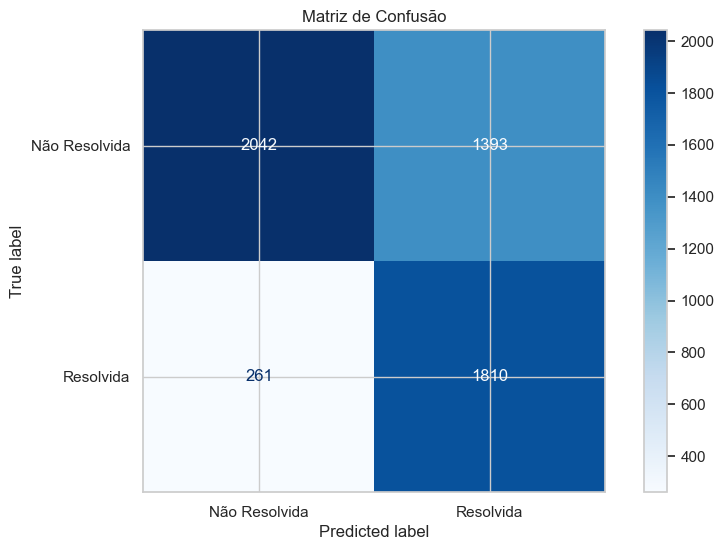

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Resolvida', 'Resolvida'])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
df_amazon_modelo = pd.get_dummies(df_amazon)
df_amazon_modelo

,ano_abertura,mes_abertura,data_abertura,data_resposta,data_analise,data_recusa,data_finalizacao,prazo_resposta,nota_consumidor,tempo_resposta_meses,...,arquivo_origem_basecompleta2024-07.csv,arquivo_origem_basecompleta2024-08.csv,arquivo_origem_basecompleta2024-09.csv,arquivo_origem_basecompleta2024-10.csv,arquivo_origem_basecompleta2024-11.csv,arquivo_origem_basecompleta2024-12.csv,arquivo_origem_basecompleta2025-01.csv,arquivo_origem_basecompleta2025-02.csv,arquivo_origem_basecompleta2025-03.csv,arquivo_origem_basecompleta2025-04.csv
0,2020,12,2020-12-23,2020-12-29,NaT,NaT,2020-12-29,2021-01-07,5.0,0,...,False,False,False,False,False,False,False,False,False,False
1,2020,12,2020-12-23,2020-12-29,NaT,NaT,2020-12-29,2021-01-07,5.0,0,...,False,False,False,False,False,False,False,False,False,False
2,2020,12,2020-12-24,2020-12-29,NaT,NaT,2020-12-29,2021-01-08,5.0,0,...,False,False,False,False,False,False,False,False,False,False
3,2020,12,2020-12-25,NaT,2020-12-30,2020-12-30,2020-12-30,2021-01-09,NaN,0,...,False,False,False,False,False,False,False,False,False,False
4,2020,12,2020-12-26,2020-12-29,NaT,NaT,2020-12-29,2021-01-10,5.0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42552,2025,4,2025-04-25,2025-04-29,NaT,NaT,2025-04-29,2025-05-05,5.0,0,...,False,False,False,False,False,False,False,False,False,True
42553,2025,4,2025-04-25,2025-04-29,NaT,NaT,2025-04-29,2025-05-05,5.0,0,...,False,False,False,False,False,False,False,False,False,True
42554,2025,4,2025-04-25,2025-04-29,NaT,NaT,2025-04-30,2025-05-05,5.0,0,...,False,False,False,False,False,False,False,False,False,True
42555,2025,4,2025-04-25,2025-04-29,NaT,NaT,2025-04-29,2025-05-05,4.0,0,...,False,False,False,False,False,False,False,False,False,True


C:\Users\ale\AppData\Local\Temp\ipykernel_12052\1100918435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amazon['Target'] = df_amazon['Respondida'].map({'S': 1, 'N': 0})
C:\Users\ale\AppData\Local\Temp\ipykernel_12052\1100918435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amazon['Target1'] = df_amazon['procurou_empresa'].map({'S': 1, 'N': 0})
C:\Users\ale\AppData\Local\Temp\ipykernel_12052\1100918435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Accuracy: 0.699600435888122


              precision    recall  f1-score   support

           0       0.89      0.59      0.71      3435
           1       0.57      0.87      0.69      2071

    accuracy                           0.70      5506
   macro avg       0.73      0.73      0.70      5506
weighted avg       0.77      0.70      0.70      5506



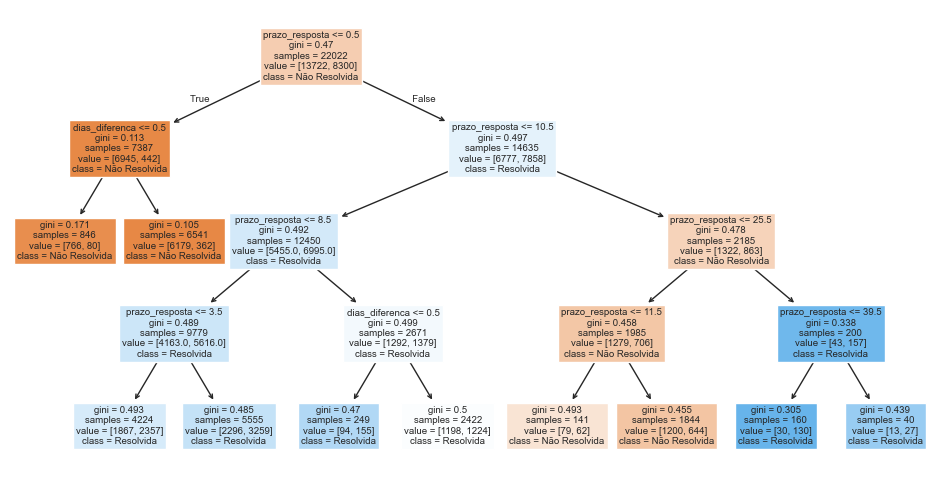

In [ ]:
# 3. Preparo dos dados
df_amazon['Target'] = df_amazon['Respondida'].map({'S': 1, 'N': 0})
df_amazon['Target1'] = df_amazon['procurou_empresa'].map({'S': 1, 'N': 0})
df_amazon['Target2'] = df_amazon['avaliacao_reclamacao'].map({'Resolvida': 1, 'Não Resolvida': 0})
#df_amazon = df_amazon.dropna(subset=['avaliacao_reclamacao'])  # Remove onde não sabemos se foi resolvida

# 4. Selecionando variáveis para predição
colunas_features = ['prazo_resposta', 'dias_diferenca', 'procurou_empresa', 'Respondida']
x = df_amazon[[ 'dias_diferenca', 'procurou_empresa', 'Target']]
y = df_amazon['Target2']  # Alvo: Avaliação da Reclamação

# 5. Treinamento/Teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(x_train, y_train)

# 6. Avaliação
y_pred = modelo.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 7. Visualização do modelo (opcional)
plt.figure(figsize=(12, 6))
plot_tree(modelo, feature_names=colunas_features, class_names=['Não Resolvida', 'Resolvida'], filled=True)
plt.show()


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>)

In [ ]:
df_amazon


,gestor,canal_origem,regiao,uf,cidade,sexo,faixa_etaria,ano_abertura,mes_abertura,data_abertura,...,Situação,avaliacao_reclamacao,nota_consumidor,analise_recusa,arquivo_origem,tempo_resposta_meses,dias_diferenca,mes_ano,Target,Target2
0,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,M,entre 31 a 40 anos,2020,12,2020-12-23,...,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,6.0,2020-12,1,1.0
1,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 21 a 30 anos,2020,12,2020-12-23,...,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,6.0,2020-12,1,1.0
2,Fundação de Proteção e Defesa do Consumidor,Plataforma Web,SE,SP,São Paulo,F,entre 41 a 50 anos,2020,12,2020-12-24,...,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,5.0,2020-12,1,1.0
3,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Aparecida de Goiânia,F,entre 51 a 60 anos,2020,12,2020-12-25,...,Cancelada,Não Resolvida,NaN,Procedente,amplo2020-12.csv,0,0.0,2020-12,0,0.0
4,Fundação de Proteção e Defesa do Consumidor,Plataforma Android,SE,SP,Campinas,M,entre 31 a 40 anos,2020,12,2020-12-26,...,Finalizada avaliada,Resolvida,5.0,NaN,amplo2020-12.csv,0,3.0,2020-12,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42552,Secretaria de Justiça e Direitos Humanos - Sec...,Plataforma Web,NE,PE,Jaboatão dos Guararapes,M,entre 41 a 50 anos,2025,4,2025-04-25,...,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0,2025-04,1,1.0
42553,Superintendência de Proteção e Defesa do Consu...,Plataforma Web,CO,GO,Águas Lindas de Goiás,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0,2025-04,1,1.0
42554,Secretaria Nacional do Consumidor,Plataforma Web,CO,DF,Brasília,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Finalizada avaliada,Resolvida,5.0,NaN,basecompleta2025-04.csv,0,4.0,2025-04,1,1.0
42555,Departamento Estadual de Proteção e Defesa do ...,Plataforma Web,S,PR,Curitiba,M,entre 31 a 40 anos,2025,4,2025-04-25,...,Finalizada avaliada,Resolvida,4.0,NaN,basecompleta2025-04.csv,0,4.0,2025-04,1,1.0


In [28]:
df_amazon['mes_ano'] = df_amazon['mes_ano'].astype(str)

In [29]:
df_amazon.to_sql('dados_amazon_procon', con='sqlite:///dados_amazon_procon.db', if_exists='replace', index=False)

df_amazon.to_csv("dados_amazon_procon.csv", index=False)